In [83]:
import numpy as np
from brainiak.isc import isc
from brainiak.utils.utils import phase_randomize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [84]:
# Set some reasonable dimensions for our dataset
n_trs = 300
n_vertices = 1 # can increase this to 10, but slow
n_subjects = 20

# Create random (normal) data
noise_data = np.random.randn(n_trs, n_vertices, n_subjects)

# Create data with signal across subjects and add noise
signal = np.random.randn(n_trs, n_vertices)
noise = 3
signal_data = []
for s in np.arange(n_subjects):
    signal_data.append(signal + np.random.randn(n_trs, n_vertices) * noise)
signal_data = np.dstack(signal_data)

In [90]:
# Demonstrate that we actually have ISCs with signal data
print(f"Mean ISC for noise data: {np.mean(isc(noise_data)):.3f}")
print(f"Mean ISC for signal data: {np.mean(isc(signal_data)):.3f}")

Mean ISC for noise data: -0.017
Mean ISC for signal data: 0.250


In [91]:
# Randomization with only test subject phase-shift
def max_isc_avg_norand(data):
    
    # Grab N for easier loop
    n_subjects = data.shape[2]
    
    # Loop through each subject
    iscs_stack = []
    for s in np.arange(n_subjects):

        # Get left-out subject
        subject = data[..., s]

        # Randomize just the left-out subject
        subject_randomized = phase_randomize(subject)

        # Get average of other subjects with no randomization
        others = np.mean([data[..., l] for l in
                          np.arange(n_subjects)
                          if l != s], axis=0)

        # Depth-stack these to feed into ISC
        isc_input = np.dstack((subject_randomized, others))

        # Compute simplified ISC
        iscs = isc(isc_input)
        iscs_stack.append(iscs)

    # Average ISCs for left-out subjects
    avg_iscs = np.mean(iscs_stack, axis=0)
    
    # Get maximum ISC across vertices 
    max_isc = np.amax(avg_iscs)
        
    return max_isc

In [92]:
# Randomization with all subjects phase-shift (prior to average)
def max_isc_avg_rand(data):
    
    # Grab N for easier loop
    n_subjects = data.shape[2]
    
    # Loop through each subject
    iscs_stack = []
    for s in np.arange(n_subjects):

        # Randomize data for each subject prior to average
        data_randomized = phase_randomize(data)
        
        # Get left-out subject
        subject_randomized = data_randomized[..., s]

        # Get average of other subjects with no randomization
        others = np.mean([data_randomized[..., l] for l in
                          np.arange(n_subjects)
                          if l != s], axis=0)

        # Depth-stack these to feed into ISC
        isc_input = np.dstack((subject_randomized, others))

        # Compute simplified ISC
        iscs = isc(isc_input)
        iscs_stack.append(iscs)

    # Average ISCs for left-out subjects
    avg_iscs = np.mean(iscs_stack, axis=0)
    
    # Get maximum ISC across vertices 
    max_isc = np.amax(avg_iscs)
        
    return max_isc

In [96]:
11 % 10

1

In [98]:
# Simple randomization iterations to create null distribution
n_iter = 1000
max_dist_norand = []
max_dist_rand = []
for i in np.arange(n_iter):
    max_dist_norand.append(max_isc_avg_norand(signal_data))
    max_dist_rand.append(max_isc_avg_rand(signal_data))
    if i > 0 and i % 100 == 0:
        print(f"Finished {i} iterations")
print("Randomize only test subject, null distribution "
      f"mean = {np.mean(max_dist_norand):.5f}, "
      f"SD = {np.std(max_dist_norand):.5f}")
print("Randomize all subjects prior to average, null distribution "
      f"mean = {np.mean(max_dist_rand):.5f}, "
      f"SD = {np.std(max_dist_rand):.5f}")

Finished 100 iterations
Finished 200 iterations
Finished 300 iterations
Finished 400 iterations
Finished 500 iterations
Finished 600 iterations
Finished 700 iterations
Finished 800 iterations
Finished 900 iterations
Randomize only test subject, null distribution mean = 0.003, SD = 0.013
Randomize all subjects prior to average, null distribution mean = 0.004, SD = 0.013


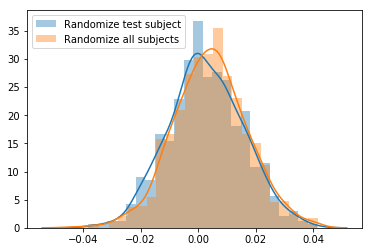

In [101]:
# Plot distributions on top of 
sns.distplot(max_dist_norand, label="Randomize test subject")
sns.distplot(max_dist_rand, label="Randomize all subjects")
plt.legend()

In [102]:
# Kolmogorov-Smirnov test for different distributions
ks_2samp(max_dist_norand, max_dist_rand)

Ks_2sampResult(statistic=0.07700000000000001, pvalue=0.004980209388706955)